In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint.

In [4]:
DATASET_NAME = 'cabspotting'
setup_string = 'g_GRU-256_rand-32_Dense-3_adam_bce_default_d_gin_GRU-128_Dense-1_adam_bce_default_{dataset}_64_100'
setup_string = setup_string.format(dataset=DATASET_NAME)

In [5]:
setup_string

'g_GRU-256_rand-32_Dense-3_adam_bce_default_d_gin_GRU-128_Dense-1_adam_bce_default_cabspotting_64_100'

In [6]:
history = pickle.load(open('histories/citybased_gan/' + setup_string + '_30.pkl', 'rb'))

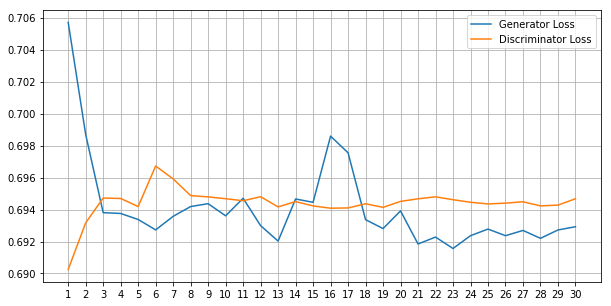

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['g_loss'], label='Generator Loss')
plt.plot(np.arange(1, 31, 1), history['d_loss'], label='Discriminator Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 30

In [9]:
# Load the model
model_path = 'checkpoints/citybased_gan/' + setup_string + '_{:02d}_g.h5'.format(SELECTED_EPOCH)
model = tf.keras.models.load_model(model_path)

## Actual generation

In [10]:
N_USERS = 8

Generate user start positions

In [11]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [12]:
user_sposs = poskde.sample(N_USERS)

Generate start and end times

In [13]:
BEGIN = pd.Timestamp('2008-05-17 10:00:04')
END = pd.Timestamp('2008-06-10 09:25:34')
duration = END - BEGIN

In [14]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [15]:
user_begins = sekde['kde_start'].sample(N_USERS)
user_begins = user_begins * duration.total_seconds()

In [16]:
user_ends = sekde['kde_end'].sample(N_USERS)
user_ends = user_ends * duration.total_seconds()

Put correctly scaled start records and end times together

In [17]:
scaler = pickle.load(open('scalers/citybased_gan/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [18]:
starts = np.concatenate([user_begins, user_sposs], axis=1)
starts = scaler.transform(starts)

In [19]:
endtimes = scaler.transform(np.concatenate([user_ends, np.zeros([len(user_ends), 2])], axis=1))[:, 0]

Actual generation loops

In [54]:
def generate_user(generator, start, endtime):
    s = np.array([start]).astype(np.float32)
    
    while(s[-1][0] <= endtime):
        print(' -> {} <= {}'.format(s[-1][0], endtime))
        
        x = s.reshape([1, -1, 3])
        noise = np.random.rand(1, 32)
        
        y = model.predict([x, noise])

        s = np.concatenate([s, y], axis=0)
    
    return s[:-1]

In [55]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, starts[u], endtimes[u])
    data.append(s)

0
 -> -1.8113161325454712 <= 1.9299601719582649
 -> -1.542542815208435 <= 1.9299601719582649
 -> -1.4081517457962036 <= 1.9299601719582649
 -> -0.7373877167701721 <= 1.9299601719582649
 -> 0.3143758773803711 <= 1.9299601719582649
 -> 0.27890926599502563 <= 1.9299601719582649
 -> 0.22594086825847626 <= 1.9299601719582649
 -> 0.24308542907238007 <= 1.9299601719582649
 -> 0.29575634002685547 <= 1.9299601719582649
 -> 0.31255555152893066 <= 1.9299601719582649
 -> 0.291297972202301 <= 1.9299601719582649
 -> 0.2972569465637207 <= 1.9299601719582649
 -> 0.2776501774787903 <= 1.9299601719582649
 -> 0.2802305817604065 <= 1.9299601719582649
 -> 0.28260505199432373 <= 1.9299601719582649
 -> 0.2636341452598572 <= 1.9299601719582649
 -> 0.2561047673225403 <= 1.9299601719582649
 -> 0.23836056888103485 <= 1.9299601719582649
 -> 0.24810896813869476 <= 1.9299601719582649
 -> 0.24425046145915985 <= 1.9299601719582649
 -> 0.23295794427394867 <= 1.9299601719582649
 -> 0.23641036450862885 <= 1.929960171958

KeyboardInterrupt: 